In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.mlab import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import pickle
import json
from mpl_toolkits.axes_grid import make_axes_locatable

/usr/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


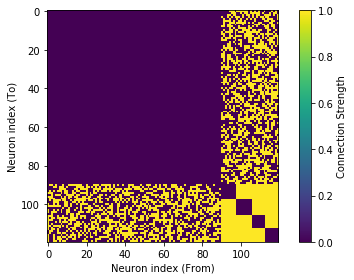

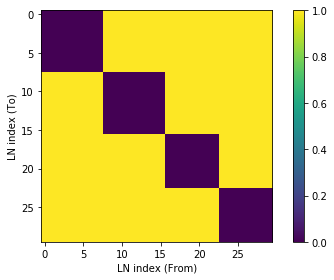

In [38]:
add = '/home/shreya/work/nerveFlow-master/interactive/'
#add = ''
G = np.load(add+'fgaba_mat.npy')
A = np.load(add+'ach_mat.npy')
M = np.add(G,A)

plt.imshow(M)
plt.colorbar(label='Connection Strength')
plt.xlabel('Neuron index (From)')
plt.ylabel('Neuron index (To)')
plt.tight_layout()
plt.savefig('/home/shreya/Notes/2019_04_02_rep/AM.png')

plt.show()

plt.imshow(G[90:,90:])
plt.colorbar()
plt.xlabel('LN index (From)')
plt.ylabel('LN index (To)')
plt.tight_layout()
plt.savefig('/home/shreya/Notes/2019_04_02_rep/LN-LN.png')

plt.show()

In [2]:
# Functions

def getData(add,nB):
    nB = 4
    for _i in list(range(1,nB+1)):
        if _i == 1:
            p1 = np.load(add + "batch1_part_1.npy")
            p2 = np.load(add + "batch1_part_2.npy")
            data = np.vstack((p1,p2))
        else:
            p1 = np.load(add + "batch" + str(_i) + "_part_1.npy")
            p2 = np.load(add + "batch" + str(_i) + "_part_2.npy")
            p = np.vstack((p1,p2))
            data = np.vstack((data,p))
    return data

def getDataInsilico(filename,neurons,st):
    infile = open(filename, 'r')
    plot_these = neurons
    volt_ids = []
    ts = []
    data = []
    for line in infile:
        if 'time' in line:
            labels = line.strip('\n').split(',')
            i = 0
            for x in labels:
                if (x[0] == 'n') and (x[-1] == 'v') and (int(x[1:-1]) in plot_these) and (st == 'v'):
                    volt_ids.append(i)
                elif (x[0] == 'n') and (x[-5:] == 'Pulse') and (int(x[1:-15]) in plot_these) and (st == 'I'):
                    volt_ids.append(i)
                i +=1

        elif ('time' not in line) and (line != '\n'):
            l1 = line.strip('\n').split(',')
            l = [float(l1[j]) for j in volt_ids]
            data.append(l)
            ts.append(float(l1[0]))

    infile.close()
    data1 = np.transpose(np.array(data))
    return data1

def getSpikeTimes(data,nPN,nLN):
    PN_tV = 40 # Threshold Potential of PNs
    LN_tV = -20 # Threshold Potential of LNs
    PN_sd = 10 # Spike duration of PNs
    LN_sd = 20 # Spike duration of LNs
    
    nN = nPN + nLN
    
    spiketimes_PN_all = []
    spiketimes_LN_all = []
       
    V_PN = np.transpose(data[:,:nPN])
    V_LN = np.transpose(data[:,nPN:nN])

    spiketimes_PN = []
    spiketimes_LN = []

    for _n in range(nLN):
        spiketimes = []
        _V = V_LN[_n,:]
        lastspiketime = -10
        for _t in range(np.size(_V)):
            if _V[_t] >= LN_tV:
                if (_t/100 - lastspiketime) > LN_sd:
                    lastspiketime = _t/100
                    spiketimes.append(_t/100)
        spiketimes_LN.append(spiketimes)
    
    for _n in range(nPN):
        spiketimes = []
        _V = V_PN[_n,:]
        lastspiketime = -10
        for _t in range(np.size(_V)):
            if _V[_t] >= PN_tV:
                if (_t/100 - lastspiketime) > PN_sd:
                    lastspiketime = _t/100
                    spiketimes.append(_t/100)
        spiketimes_PN.append(spiketimes)
    
    spiketimes_PN_all.append(spiketimes_PN)
    spiketimes_LN_all.append(spiketimes_LN)
    
    return spiketimes_PN_all,spiketimes_LN_all

In [3]:
# Overall parameters

PN_tV = 40 # Threshold Potential of PNs
LN_tV = -20 # Threshold Potential of LNs
PN_sd = 10 # Spike duration of PNs
LN_sd = 20 # Spike duration of LNs

nPN = 90
nLN = 30
nN = nPN + nLN

nB = 4

In [106]:
# Store LN spikes

# get spike data
nB = 4
spiketimes_PN_all = []
spiketimes_LN_all = []
for _ipi in range(50,550,50):
    
    print(_ipi)
    
    add = '/home/shreya/work/AL_90_30/nF/results_7/gLN0.6LNPN1.3PNLN0.1_extPN7LN4_lowPN4.5LN2_pulse50ms_IPI'+ str(_ipi) +'ms/'
    
    data = getData(add,nB)
        
    V_PN = np.transpose(data[:,:nPN])
    V_LN = np.transpose(data[:,nPN:nN])

    spiketimes_PN = []
    spiketimes_LN = []

    for _n in range(nLN):
        spiketimes = []
        _V = V_LN[_n,:]
        lastspiketime = -10
        for _t in range(np.size(_V)):
            if _V[_t] >= LN_tV:
                if (_t/100 - lastspiketime) > LN_sd:
                    lastspiketime = _t/100
                    spiketimes.append(_t/100)
        spiketimes_LN.append(spiketimes)

    print("LN spiketimes done.")
    
    for _n in range(nPN):
        spiketimes = []
        _V = V_PN[_n,:]
        lastspiketime = -10
        for _t in range(np.size(_V)):
            if _V[_t] >= PN_tV:
                if (_t/100 - lastspiketime) > PN_sd:
                    lastspiketime = _t/100
                    spiketimes.append(_t/100)
        spiketimes_PN.append(spiketimes)
    
    print("PN spiketimes done.")
    spiketimes_PN_all.append(spiketimes_PN)
    spiketimes_LN_all.append(spiketimes_LN)

50
LN spiketimes done.
PN spiketimes done.
100
LN spiketimes done.
PN spiketimes done.
150
LN spiketimes done.
PN spiketimes done.
200
LN spiketimes done.
PN spiketimes done.
250
LN spiketimes done.
PN spiketimes done.
300
LN spiketimes done.
PN spiketimes done.
350
LN spiketimes done.
PN spiketimes done.
400
LN spiketimes done.
PN spiketimes done.
450
LN spiketimes done.
PN spiketimes done.
500
LN spiketimes done.
PN spiketimes done.


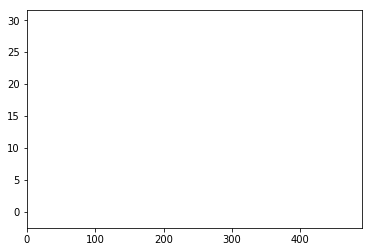

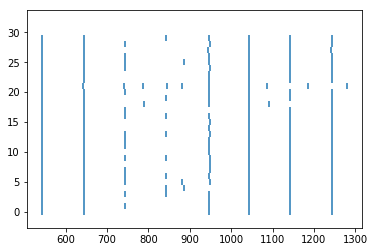

In [211]:
plt.eventplot(spiketimes_LN_all[0])
plt.xlim(0,np.size(V_LN[0])/100)
plt.show()

plt.eventplot(spiketimes_PN_all[0][30:62]) # Only these PNs fire
plt.show()

[2, 0, 1, 0, 5, 0, 2, 0, 6, 2, 8, 8, 1, 8, 8, 4, 4, 8, 8, 4, 0, 8, 7, 0, 0, 8, 3, 8, 3, 2]


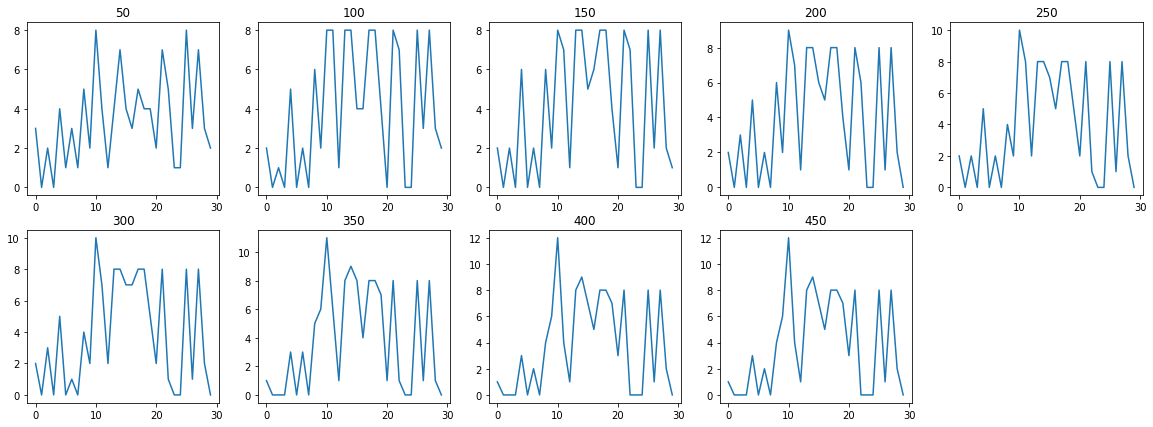

In [163]:
times_LN = [[len(_i) for _i in spiketimes_LN] for spiketimes_LN in spiketimes_LN_all]
print(times_LN[1])

plt.figure(1,figsize=(20,7))

plt.subplot(251)
plt.plot(times_LN[0])
plt.title('50')

plt.subplot(252)
plt.plot(times_LN[1])
plt.title('100')

plt.subplot(253)
plt.plot(times_LN[2])
plt.title('150')

plt.subplot(254)
plt.plot(times_LN[3])
plt.title('200')

plt.subplot(255)
plt.plot(times_LN[4])
plt.title('250')

plt.subplot(256)
plt.plot(times_LN[5])
plt.title('300')

plt.subplot(257)
plt.plot(times_LN[6])
plt.title('350')

plt.subplot(258)
plt.plot(times_LN[7])
plt.title('400')

plt.subplot(259)
plt.plot(times_LN[7])
plt.title('450')

plt.show()

[30, 10]
30


<Container object of 3 artists>

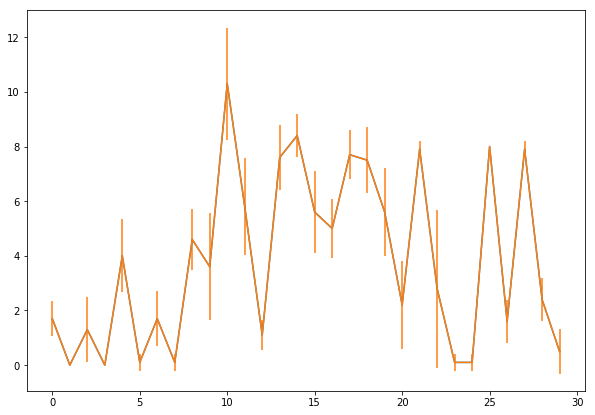

In [170]:
times_LN_N = [[times_LN[_x][_i] for _x in range(10)] for _i in range(nLN)]
print([len(times_LN_N),len(times_LN)])

times_LN_N_avg = [np.mean(x) for x in times_LN_N]
times_LN_N_sd = [np.std(x) for x in times_LN_N]
print(len(times_LN_N_avg))

plt.figure(1,figsize=(10,7))
plt.plot(times_LN_N_avg)
plt.errorbar(range(30),times_LN_N_avg,yerr=times_LN_N_sd)

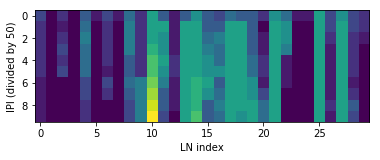

(30,)
(10,)


Text(0,0.5,u'Standard deviation of number of neurons ')

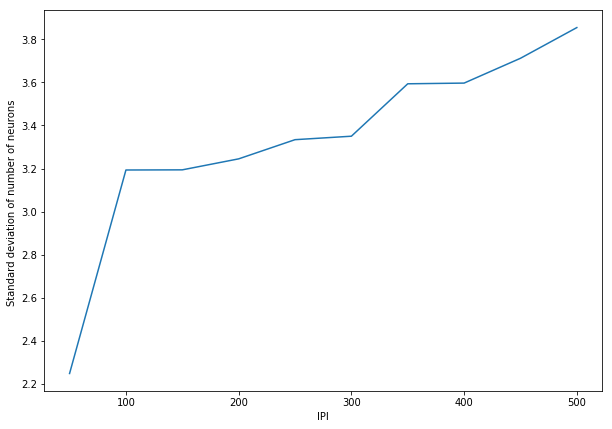

In [207]:
r = [0,1,2,3,4,5,6,7,8,9]
#for _i in r:
    #plt.plot(times_LN[_i][9:20])

#plt.legend(r)
#plt.show()

a_times_LN = np.array(times_LN)
np.shape(a_times_LN)
plt.imshow(a_times_LN)
plt.ylabel('IPI (divided by 50)')
plt.xlabel('LN index')
plt.show()

prod = np.prod(a_times_LN,0)
print(np.shape(prod))
#plt.plot(prod)

dev = [np.std(a_times_LN[i,:]) for i in range(10)]
print(np.shape(dev))
plt.figure(1,figsize=(10,7))
plt.plot(range(50,550,50), dev)
plt.xlabel('Inter Pulse Interval')
plt.ylabel('Standard deviation of number of times neurons fire')
# Standard deviation of number of times neurons fire ~ how heterogenous the responses are

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


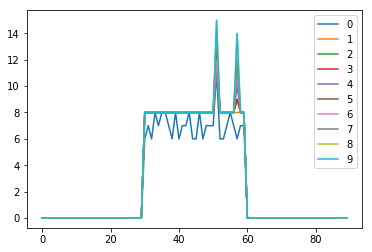

In [186]:
times_PN = [[len(_i) for _i in spiketimes_PN] for spiketimes_PN in spiketimes_PN_all]
print(times_PN[1])

r = [0,1,2,3,4,5,6,7,8,9]
for _i in r:
    plt.plot(times_PN[_i])

plt.legend(r)
plt.show()

(90, 30007)
[8.16296690e-01 4.97106014e-02 4.04993200e-02 2.39246266e-02
 1.79098781e-02 1.18090718e-02 1.15286006e-02 8.43262352e-03
 5.17036562e-03 4.54030905e-03 3.30912785e-03 2.06432729e-03
 1.67434404e-03 1.07789094e-03 7.20030177e-04 5.43813758e-04
 2.61810179e-04 1.76733599e-04 9.19627008e-05 6.74294713e-05
 5.61526818e-05 3.57882564e-05 2.84409845e-05 1.77473878e-05
 1.56837040e-05 1.21721263e-05 7.60095491e-06 3.97809474e-06
 3.59740674e-06 2.52400782e-06 1.88180067e-06 1.35782304e-06
 7.71420709e-07 7.17903334e-07 4.44617042e-07 4.11142688e-07
 3.51287176e-07 2.80650785e-07 1.30716172e-07 1.28454311e-07
 7.62965677e-08 5.24270745e-08 4.20226106e-08 3.03922557e-08
 2.25027859e-08 1.35572803e-08 8.86342329e-09 7.25215249e-09
 5.17955361e-09 3.83060632e-09 2.86035182e-09 2.27260733e-09
 2.03310864e-09 1.90274678e-09 1.37527556e-09 1.20031472e-09
 9.37037627e-10 7.05822366e-10 6.63628344e-10 5.25211199e-10
 4.86616489e-10 4.35119554e-10 3.52464703e-10 3.33010304e-10
 3.15160094e

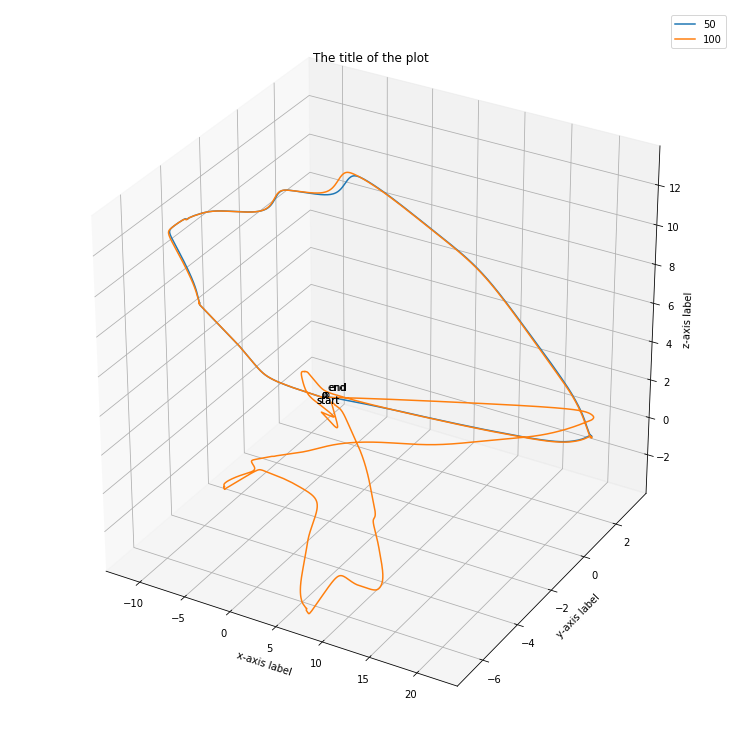

In [123]:
pdl = [50,100]
j = -1
# Get pca axis on basis of:
add = '/home/shreya/work/AL_90_30/nF1/results/gLN0.6LNPN1.3PNLN0.1_extPN7LN4_lowPN4.5LN2_pd'+ str(pdl[j])+'/'
data_longinp = getData(add,4)
V_PN_longinp = np.transpose(data_longinp[:,:nPN])
V_LN_longinp = np.transpose(data_longinp[:,nPN:nN])

print(np.shape(V_PN_longinp[:,50000:]))
myData = np.array(np.transpose(V_PN_longinp[:,50000:]))
results = PCA(myData)

#this will return an array of variance percentages for each component
results.fracs
print(results.fracs)

# Initialize figure
fig1 = plt.figure(figsize=(10,10)) # Make a plotting figure
ax = Axes3D(fig1) # use the plotting figure to create a Axis3D object.

for pd in pdl:
    
    if pd != pdl[j]:
        add = '/home/shreya/work/AL_90_30/nF1/results/gLN0.6LNPN1.3PNLN0.1_extPN7LN4_lowPN4.5LN2_pd'+ str(pd)+'/'
        data_longinp = getData(add,4)
        V_PN_longinp = np.transpose(data_longinp[:,:nPN])
        V_LN_longinp = np.transpose(data_longinp[:,nPN:nN])

        myData1 = np.array(np.transpose(V_PN_longinp[:,50000:]))
    
        res = results.project(myData1)
    else:
        res = results.project(myData)
        
    x = []
    y = []
    z = []
    for item in res:
        x.append(item[0])
        y.append(item[1])
        z.append(item[2])

    pltData = [x,y,z]
    print(len(pltData[0]))
    ax.plot(pltData[0], pltData[1], pltData[2],) # make a scatter plot of blue dots from the data

    ax.text(pltData[0][0], pltData[1][0], pltData[2][0], 'o')
    ax.text(pltData[0][0]-0.2, pltData[1][0]-0.2, pltData[2][0]-0.2, 'start')

    ax.text(pltData[0][-1], pltData[1][-1], pltData[2][-1], 'o')
    ax.text(pltData[0][-1]+0.2, pltData[1][-1]+0.2, pltData[2][-1]+0.2, 'end')


# label the axes 
ax.set_xlabel("x-axis label") 
ax.set_ylabel("y-axis label")
ax.set_zlabel("z-axis label")
ax.set_title("The title of the plot")
plt.legend(pdl)
plt.show() # show the plot


In [6]:
#http://blog.nextgenetics.net/?e=42

#construct your numpy array of data
print(np.shape(V_PN_longinp[:,50000:]))
myData = np.array(np.transpose(V_PN_longinp[:,50000:]))
results = PCA(myData)

#this will return an array of variance percentages for each component
results.fracs

#this will return a 2d array of the data projected into PCA space
results.Y 

(90, 30007)


array([[-6.04431814e+00,  6.51394674e-01, -4.91301017e-01, ...,
         2.47715385e-06,  4.00411364e-06,  2.92248953e-06],
       [-6.04431814e+00,  6.51394674e-01, -4.91301017e-01, ...,
         2.47715192e-06,  4.00411310e-06,  2.92248847e-06],
       [-6.04431814e+00,  6.51394674e-01, -4.91301017e-01, ...,
         2.47714999e-06,  4.00411256e-06,  2.92248742e-06],
       ...,
       [-5.89990051e+00,  6.67395281e-01, -4.85672057e-01, ...,
         1.32127561e-06,  1.57401842e-06,  1.66483696e-06],
       [-5.90000116e+00,  6.67384122e-01, -4.85675927e-01, ...,
         1.32417345e-06,  1.57338054e-06,  1.66785253e-06],
       [-5.90010175e+00,  6.67372969e-01, -4.85679795e-01, ...,
         1.32780500e-06,  1.57640675e-06,  1.66953627e-06]])

30007


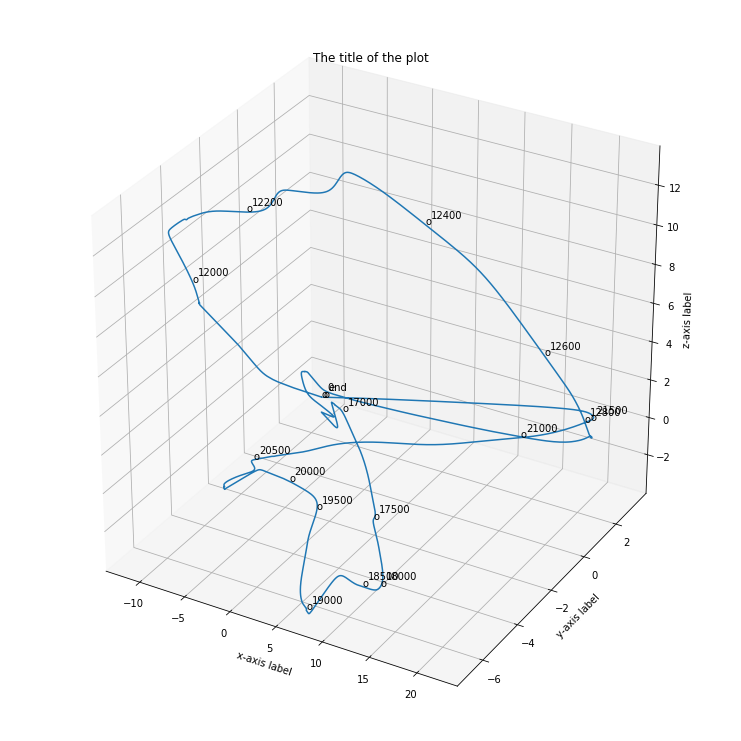

In [34]:
x = []
y = []
z = []
for item in results.Y:
    x.append(item[0])
    y.append(item[1])
    z.append(item[2])

plt.close('all') # close all latent plotting windows
fig1 = plt.figure(figsize=(10,10)) # Make a plotting figure
ax = Axes3D(fig1) # use the plotting figure to create a Axis3D object.

pltData = [x,y,z]
print(len(pltData[0]))
ax.plot(pltData[0], pltData[1], pltData[2]) # make a scatter plot of blue dots from the data

ax.text(pltData[0][0], pltData[1][0], pltData[2][0], 'o')
ax.text(pltData[0][0]+0.2, pltData[1][0]+0.2, pltData[2][0]+0.2, str(0))

ax.text(pltData[0][-1], pltData[1][-1], pltData[2][-1], 'o')
ax.text(pltData[0][-1]+0.2, pltData[1][-1]+0.2, pltData[2][-1]+0.2, 'end')

for _i in range(12000,13000,200):
    ax.text(pltData[0][_i], pltData[1][_i], pltData[2][_i], 'o')
    ax.text(pltData[0][_i]+0.2, pltData[1][_i]+0.2, pltData[2][_i]+0.2, str(_i))
    
for _i in range(17000,22000,500):
    ax.text(pltData[0][_i], pltData[1][_i], pltData[2][_i], 'o')
    ax.text(pltData[0][_i]+0.2, pltData[1][_i]+0.2, pltData[2][_i]+0.2, str(_i))
"""
# make simple, bare axis lines through space:
xAxisLine = ((min(pltData[0]), max(pltData[0])), (0, 0), (0,0)) # 2 points make the x-axis line at the data extrema along x-axis 
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r') # make a red line for the x-axis.
yAxisLine = ((0, 0), (min(pltData[1]), max(pltData[1])), (0,0)) # 2 points make the y-axis line at the data extrema along y-axis
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r') # make a red line for the y-axis.
zAxisLine = ((0, 0), (0,0), (min(pltData[2]), max(pltData[2]))) # 2 points make the z-axis line at the data extrema along z-axis
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r') # make a red line for the z-axis.


points = np.array([x,y,z]).T.reshape(-1,1,3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

print(np.shape(segments))
,c = plt.cm.jet(np.linspace(0,1,len(x)))

"""
# label the axes 
ax.set_xlabel("x-axis label") 
ax.set_ylabel("y-axis label")
ax.set_zlabel("z-axis label")
ax.set_title("The title of the plot")
plt.show() # show the plot


In [43]:
g = [1,2,3,4,5]
g[1:]

[2, 3, 4, 5]

In [282]:

ax.scatter(pltData[0], pltData[1], pltData[2], '.') # make a scatter plot of blue dots from the data
"""
# make simple, bare axis lines through space:
xAxisLine = ((min(pltData[0]), max(pltData[0])), (0, 0), (0,0)) # 2 points make the x-axis line at the data extrema along x-axis 
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r') # make a red line for the x-axis.
yAxisLine = ((0, 0), (min(pltData[1]), max(pltData[1])), (0,0)) # 2 points make the y-axis line at the data extrema along y-axis
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r') # make a red line for the y-axis.
zAxisLine = ((0, 0), (0,0), (min(pltData[2]), max(pltData[2]))) # 2 points make the z-axis line at the data extrema along z-axis
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r') # make a red line for the z-axis.
"""
# label the axes 
ax.set_xlabel("x-axis label") 
ax.set_ylabel("y-axis label")
ax.set_zlabel("y-axis label")
ax.set_title("The title of the plot")
plt.show() # show the plot

[[ 0.00000000e+00  1.00000000e-02  2.00000000e-02 ...  1.25400000e+01
   1.25500000e+01  1.25600000e+01]
 [ 0.00000000e+00  9.99983333e-03  1.99986667e-02 ... -2.63675581e-02
  -1.63698832e-02 -6.37057127e-03]]
[[[ 0.00000000e+00  0.00000000e+00]]

 [[ 1.00000000e-02  9.99983333e-03]]

 [[ 2.00000000e-02  1.99986667e-02]]

 ...

 [[ 1.25400000e+01 -2.63675581e-02]]

 [[ 1.25500000e+01 -1.63698832e-02]]

 [[ 1.25600000e+01 -6.37057127e-03]]]


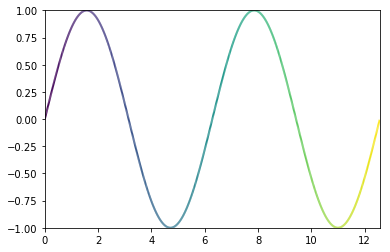

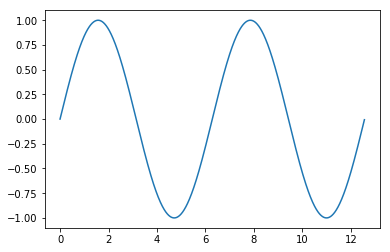

In [277]:
x = np.arange(0,4*np.pi,0.01)
y = np.sin(x)

print(np.array([x,y]))
points = np.array([x, y]).T.reshape(-1, 1, 2)
print(points)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots()
norm = plt.Normalize(x.min(),x.max())
lc = LineCollection(segments, cmap='viridis',norm=norm)
lc.set_array(x)
lc.set_linewidth(2)
axs.add_collection(lc)
axs.set_xlim(x.min(),x.max())
axs.set_ylim(-1,1)
plt.show()

plt.plot(x,y)
plt.show()

In [295]:
x1 = range(50,550,50)
x2 = range(0,15,2)

with open('check_json1.txt', 'w') as outfile:
    json.dump(x1, outfile)
    
with open('check_json1.txt', 'r') as infile:
    y1 = json.load(infile)
    
print(y1)

AttributeError: 'str' object has no attribute 'read'

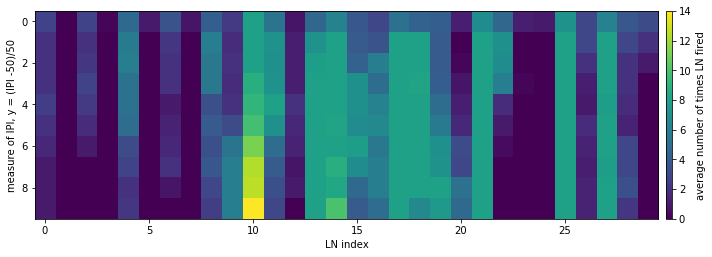

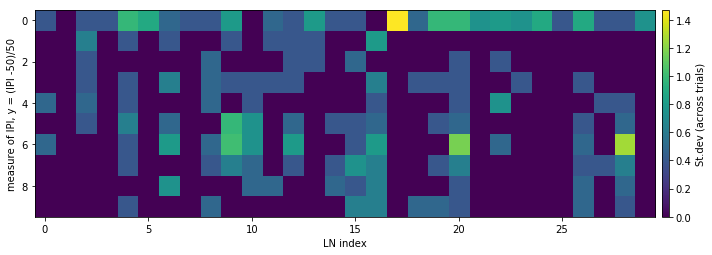

[0.58690171 0.12774852 0.09932653 0.2051603  0.15393418 0.22700242
 0.31196095 0.21893505 0.15434256 0.14748343]


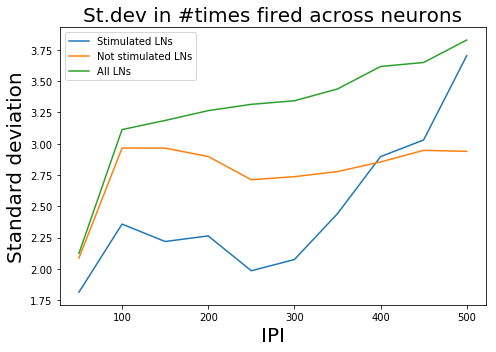

In [29]:
# Store LN spikes

# get spike data
nB = 4

times_LN_all = []
   
for _ipi in range(50,550,50):
    T_LN = []
    for _x in [1,2,3,4,5]:
        add = '/home/shreya/work/AL_90_30/nF1/results_7/gLN0.6LNPN1.3PNLN0.1_extPN7LN4_lowPN4.5LN2_pulse50ms_IPI'+ str(_ipi) + 'ms_' + str(_x) + '/'

        #with open(add + 'spiketimes_PN.json', 'r') as f1:
            #spt_PN = json.load(f1)
        with open(add + 'spiketimes_LN.json', 'r') as f2:
            spt_LN = json.load(f2)
            
        times_LN = [len(_i) for _i in spt_LN]
        
        T_LN.append(times_LN)
        
    #plt.imshow(T_LN)
    #plt.show()
    
    times_LN_all.append(T_LN)
    
    meanT_LN = np.mean(np.array(T_LN),0)
    #print(np.shape(meanT_LN))
    
    stdT_LN = np.std(np.array(T_LN),axis=0)
    #print(np.shape(stdT_LN))
    
    if _ipi == 50:
        meanT_LN_all = meanT_LN
        stdT_LN_all = stdT_LN
    else:
        meanT_LN_all = np.vstack((meanT_LN_all, meanT_LN))
        stdT_LN_all = np.vstack((stdT_LN_all, stdT_LN))

np.shape(meanT_LN_all)

plt.figure(1,figsize=(10,5))
img2 = plt.imshow(meanT_LN_all)
plt.xlabel('LN index')
plt.ylabel('measure of IPI, y = (IPI -50)/50')
divider = make_axes_locatable(plt.gca())
cax2 = divider.append_axes("right","1%",pad=0.1)
c2 = plt.colorbar(img2,cax=cax2)
plt.ylabel('average number of times LN fired')
plt.tight_layout()
plt.savefig('mean_pulse_random.png')
plt.show()

plt.figure(2,figsize=(10,5))
img1 = plt.imshow(stdT_LN_all)
plt.xlabel('LN index')
plt.ylabel('measure of IPI, y = (IPI -50)/50')
divider = make_axes_locatable(plt.gca())
cax1 = divider.append_axes("right","1%",pad=0.1)
c1 = plt.colorbar(img1,cax=cax1)
plt.ylabel('St.dev (across trials)')
plt.tight_layout()
plt.savefig('stdev_pulse_random.png')
plt.show()

std_LN_times = np.mean(stdT_LN_all,axis=1)
print(std_LN_times)

std_LN_in_one_ipi_sLN = np.std(meanT_LN_all[:,10:20],1)
idx =range(10) + range(20,30)
std_LN_in_one_ipi_nsLN = np.std(meanT_LN_all[:,idx],1)
std_LN_in_one_ipi_aLN = np.std(meanT_LN_all[:,:],1)

x_axis = range(50,550,50)
plt.figure(3,figsize=(7,5))
plt.plot(x_axis, std_LN_in_one_ipi_sLN)
plt.plot(x_axis, std_LN_in_one_ipi_nsLN)
plt.plot(x_axis, std_LN_in_one_ipi_aLN)
plt.title('St.dev in #times fired across neurons',fontsize=20)
plt.xlabel('IPI',fontsize=20)
plt.ylabel('Standard deviation',fontsize=20)
plt.legend(['Stimulated LNs', 'Not stimulated LNs', 'All LNs'])
plt.tight_layout()
plt.savefig('stdev_pulse_random_across_IPI.png')
plt.show()

(30, 9)


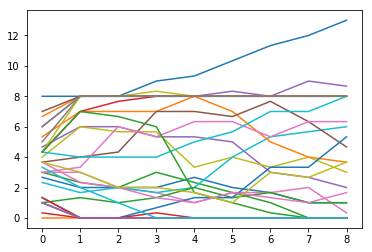

In [105]:
# take only for neuron 10 say
times_across_ipi = [[np.mean(np.array([_i[_x][_n] for _x in range(3)])) for _i in times_LN_all] for _n in range(30)]
print(np.shape(times_across_ipi))

for i in range(30):
    plt.plot(range(9), times_across_ipi[i])

In [12]:
func_x1 = np.arange(0,10)
func_x = np.vstack((func_x1,)*5)
func_y = np.zeros((5,10))
for _i in range(5):
    i = _i+1
    func_y1 = i*np.sin(func_x1 + i)
    func_y[_i,:] = func_y1    
print(func_y)

[[ 0.84147098  0.90929743  0.14112001 -0.7568025  -0.95892427 -0.2794155
   0.6569866   0.98935825  0.41211849 -0.54402111]
 [ 1.81859485  0.28224002 -1.51360499 -1.91784855 -0.558831    1.3139732
   1.97871649  0.82423697 -1.08804222 -1.99998041]
 [ 0.42336002 -2.27040749 -2.87677282 -0.83824649  1.9709598   2.96807474
   1.23635546 -1.63206333 -2.99997062 -1.60971875]
 [-3.02720998 -3.8356971  -1.11766199  2.62794639  3.95743299  1.64847394
  -2.17608444 -3.99996083 -2.14629167  1.68066815]
 [-4.79462137 -1.39707749  3.28493299  4.94679123  2.06059243 -2.72010555
  -4.99995103 -2.68286459  2.10083518  4.95303678]]


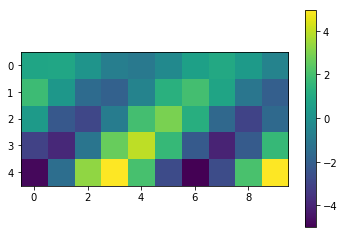

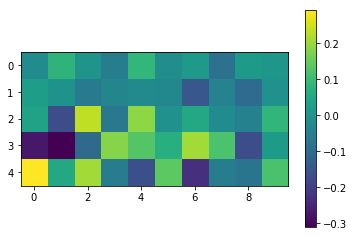

In [15]:
noise_y = np.random.uniform(-0.1*func_y,0.1*func_y,(5,10))
plt.imshow(func_y)
plt.colorbar()
plt.show()
plt.imshow(noise_y)
plt.colorbar()
plt.show()

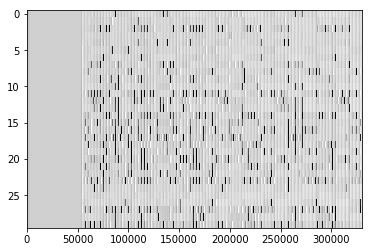

In [34]:
nB = 8
add = '/home/shreya/work/AL_90_30/nF1/results/gLN0.6LNPN1.0PNLN0.1_extPN9LN4_lowPN5.5LN2_k-part_pd6000_thPN7.5LN2.5_IPI100ms_5/'
current = np.load(add+'current.npy')
#plt.plot(current[15,:])
#plt.show()
data = getData(add,nB)
plt.imshow(np.transpose(data)[30:60,:],aspect='auto',cmap='binary')
plt.show()

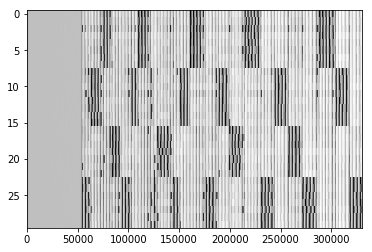

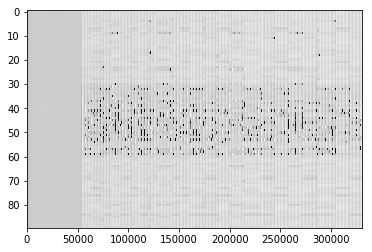

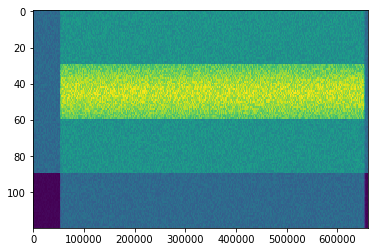

In [35]:
plt.imshow(np.transpose(data)[90:120,:],aspect='auto',cmap='binary')
plt.show()
plt.imshow(np.transpose(data)[:90,:],aspect='auto',cmap='binary')
plt.show()
plt.imshow(current[:,:],aspect='auto')
plt.show()

In [36]:
spt_PN,spt_LN = getSpikeTimes(data,90,30)

In [27]:
# read spiketimes
add = '/home/shreya/work/AL_90_30/nF1/results/gLN0.6LNPN1.0PNLN0.1_extPN9LN4_lowPN5.5LN2_k-part_pd6000_thPN7.5LN2.5_IPI100ms_3/'
with open(add+'spiketimes_PN.json', 'r') as f:
    spt_PN = json.load(f)
with open(add+'spiketimes_LN.json', 'r') as f:
    spt_LN = json.load(f)

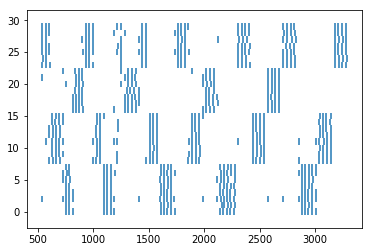

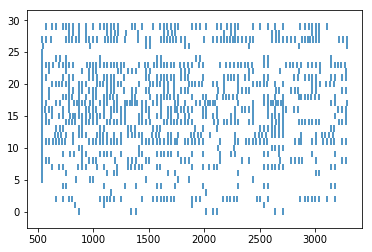

In [37]:
#print(spt_LN[0])

plt.eventplot(spt_LN[0])
plt.show()

plt.eventplot(spt_PN[0][30:60]) # Only these PNs fire
plt.show()

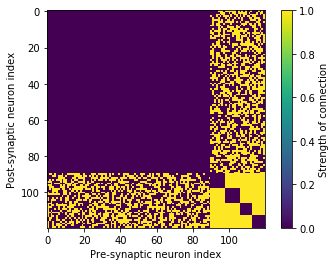

In [6]:
add = '/home/shreya/dump/'
AM_GABA = np.load(add+'fgaba_mat_k-part.npy')
AM_ACH = np.load(add+'ach_mat_k-part.npy')

plt.imshow(AM_GABA+AM_ACH)
plt.xlabel('Pre-synaptic neuron index')
plt.ylabel('Post-synaptic neuron index')
plt.colorbar(label='Strength of connection')
plt.savefig('/home/shreya/Notes/presentation/AM_k-part.png')
plt.show()

In [48]:
# plot the KCA current

add = '/home/shreya/work/AL_90_30/nF1/results_random/gLN0.6LNPN1.0PNLN0.1_extPN7.5LN4_lowPN5.5LN2_pd50_thPN7LN3.3_IPI50ms_1/'
nB = 4

data = getData(add, nB)

current = np.load(add+'current.npy')

In [51]:
V_PN = np.transpose(data)[:nPN,:]
V_LN = np.transpose(data)[nPN:nN,:]
m_kca_LN = np.transpose(data)[nN:,:]
t_len = len(V_LN[15,:])

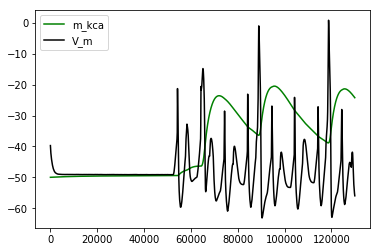

In [59]:
scale_m_kca = m_kca_LN*500 - 50
_n = 18
plt.plot(range(t_len),scale_m_kca[_n,:],'g-', V_LN[_n,:], 'k-')
plt.legend(['m_kca', 'V_m'])
plt.show()

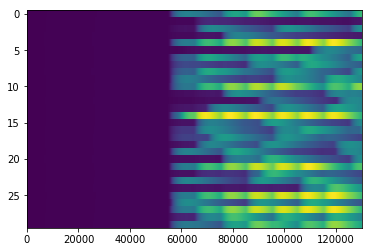

In [53]:
plt.imshow(m_kca_LN, aspect='auto')
plt.show()

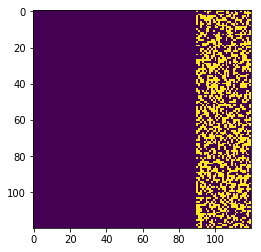

In [3]:
# generate sgaba matrix from fgaba matrix
add = '/home/shreya/work/nerveFlow-master/interactive/'
fgaba_mat = np.load(add+'fgaba_mat.npy')
plt.imshow(fgaba_mat)
plt.show()

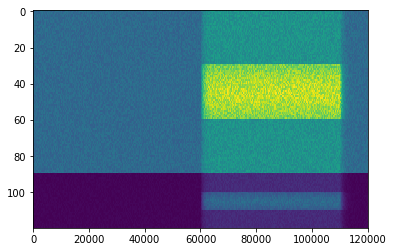

In [6]:
#current
add = '/home/shreya/work/nerveFlow-master/interactive/'
current = np.load(add+'current.npy')
plt.imshow(current,aspect='auto')
plt.show()